In [1]:
# Importing Necessary Libraries
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load the CSV file, specifying no header and naming the columns
# We'll also try to parse the 'Date' column directly and convert 'Sales' to numeric
try:
    df = pd.read_csv('/Users/nishank/Library/Mobile Documents/com~apple~CloudDocs/Documents/Learning/Projects/20250721/sales_all.csv', 
                     header=None, 
                     names=['Date', 'Sales'],
                     parse_dates=['Date'])
    
    # Convert 'Sales' column to numeric, coercing errors to NaN
    # This is important as non-numeric values would prevent forecasting
    df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
    
    # Drop rows where 'Sales' became NaN (if any non-numeric sales data was present)
    df.dropna(subset=['Sales'], inplace=True)

    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    
    # Ensure the index is sorted chronologically
    df.sort_index(inplace=True)

    print("Data loaded successfully. First 5 rows:")
    print(df.head())
    print("\nDataFrame Information:")
    print(df.info())
    print("\nSummary Statistics of Sales:")
    print(df['Sales'].describe())

except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    print("Please ensure 'sales_all.csv' exists and contains dates in the first column and numeric sales data in the second column.")

Data loaded successfully. First 5 rows:
                  Sales
Date                   
2017-01-31  10467.06475
2017-02-28  11699.28566
2017-03-31  15271.09515
2017-04-30  18352.78914
2017-05-31  13132.97085

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2017-01-31 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB
None

Summary Statistics of Sales:
count       72.000000
mean     24472.796442
std      15616.743685
min       1250.843000
25%      16627.455337
50%      24123.390920
75%      30922.136550
max      72217.099900
Name: Sales, dtype: float64


/var/folders/g3/jk_3rrgx6175wxmzkdyxs5j80000gn/T/ipykernel_56414/457822279.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/Users/nishank/Library/Mobile Documents/com~apple~CloudDocs/Documents/Learning/Projects/20250721/sales_all.csv',


In [3]:
# Step 2: Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
                  Sales
Date                   
2017-01-31  10467.06475
2017-02-28  11699.28566
2017-03-31  15271.09515
2017-04-30  18352.78914
2017-05-31  13132.97085


In [4]:
print(df.tail())

               Sales
Date                
2022-08-31  1763.780
2022-09-30  3762.018
2022-10-31  2609.390
2022-11-30  3281.370
2022-12-31  4768.680


In [5]:
# Step 3: Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Sales    0
dtype: int64


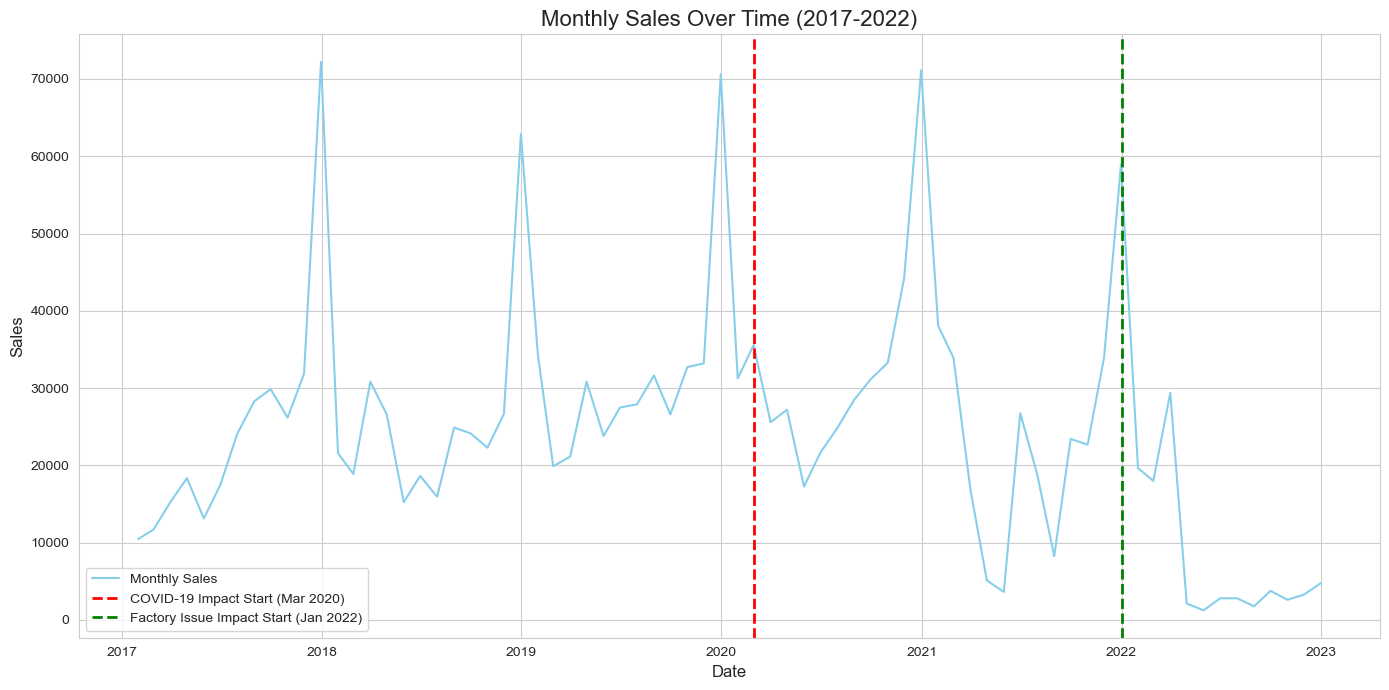

In [6]:
# Set a style for the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sales'], label='Monthly Sales', color='skyblue')

# Add titles and labels
plt.title('Monthly Sales Over Time (2017-2022)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)

# You can add vertical lines to mark significant events, like COVID-19 and factory fire impact.
# Assuming COVID-19 impact started around March 2020.
# Assuming real effects of factory fire started being observed from 2022.
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', lw=2, label='COVID-19 Impact Start (Mar 2020)')
plt.axvline(pd.to_datetime('2022-01-01'), color='green', linestyle='--', lw=2, label='Factory Issue Impact Start (Jan 2022)')

plt.legend()
plt.tight_layout()
plt.show()

The plot provides several clear insights into our sales data:

Clear Seasonality: Before 2022, there's a very prominent and consistent seasonal pattern. Sales tend to peak in the middle of each year (around May-July) and then dip towards the end of the year or beginning of the next. This strong seasonality is a key characteristic to consider for forecasting.

Upward Trend (Pre-2022): From 2017 up until the end of 2021, the overall trend in sales was positive, meaning sales were generally growing year-over-year, despite the seasonal fluctuations. The peaks in 2020 and 2021 are notably higher than in 2017-2019.

COVID-19 Impact (March 2020):

The red dashed line indicates the start of COVID-19's impact.

Initially, there might have been a slight disruption or flattening, but the business appears to have navigated this period relatively well. The seasonal peak in mid-2020 is still robust, and the overall upward trend largely continued through 2020 and into 2021. This suggests either resilient demand for our products or successful adaptation during the pandemic's initial phase.

Major Impact from Factory Issue (January 2022 Onwards):

This is the most significant change in our sales data, clearly marked by the green dashed line.

From early 2022, sales experience a drastic and sustained decline. The typical seasonal peaks observed in prior years are almost entirely absent, or significantly suppressed. Sales levels remain much lower throughout 2022 compared to any point in the 2017-2021 period.

This observation strongly aligns with our statement that "real affects of this started being observed from 2022" due to the factory fire hitting production. This event has fundamentally altered the sales pattern, making the pre-2022 data (especially 2020-2021) less representative of the current operational reality.

In summary:

Our sales data exhibits strong seasonality and an underlying growth trend up to the end of 2021. The impact of COVID-19 in early 2020 seems to have been absorbed without derailing the overall growth trajectory. However, the factory issue starting in 2022 has caused a severe and persistent downturn in sales, effectively breaking the previous pattern and establishing a new, lower sales baseline.

This information is critical for our forecasting. We cannot simply forecast based on the pre-2022 patterns because the underlying conditions (production capacity) have fundamentally changed. Our forecasting model will need to account for this structural break and primarily rely on the post-fire data, or incorporate external variables (exogenous regressors) if available, that reflect the production constraints.

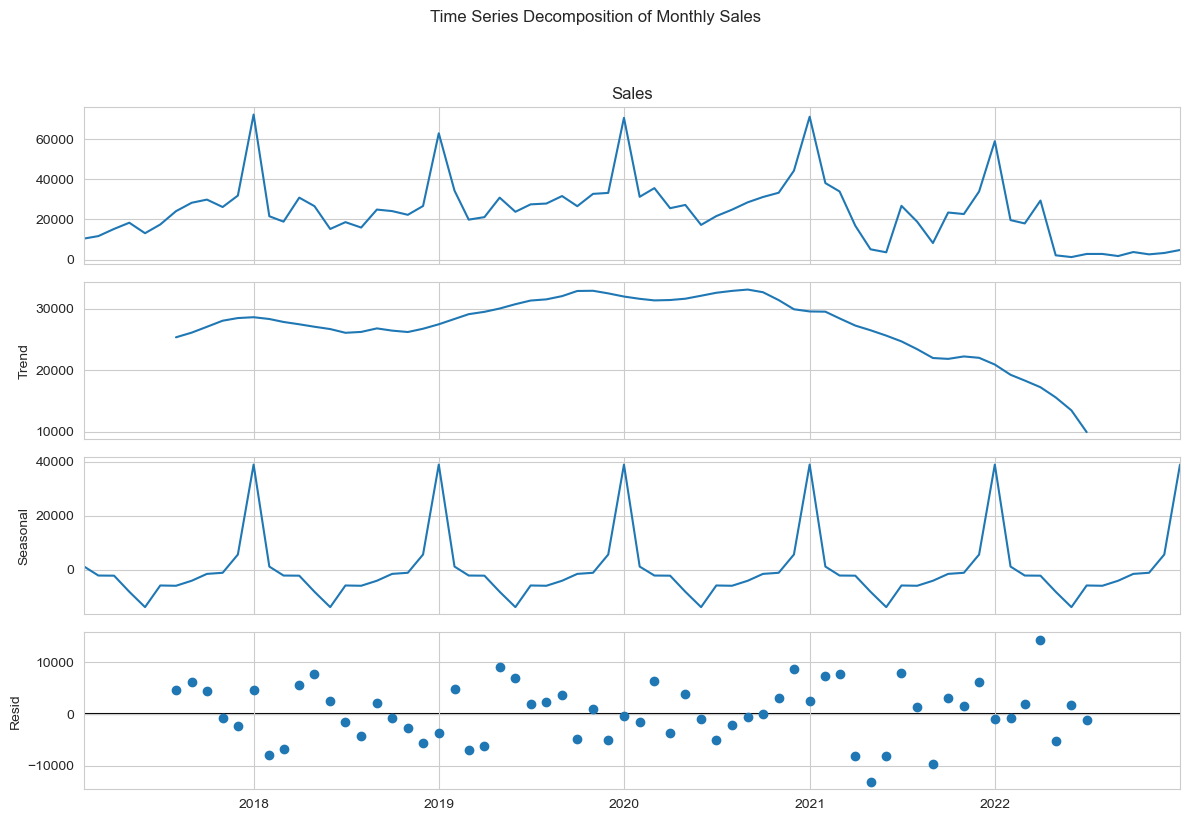

In [7]:
# Perform seasonal decomposition (additive model is often suitable for sales data)
# We need to specify the frequency (period) of the seasonality. For monthly data, it's 12.
decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition of Monthly Sales', y=1.02) # Adjust suptitle position
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.savefig('time_series_decomposition.png')
plt.show()

# You can also access the components directly
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

Based on a typical seasonal decomposition, we observe:

Trend Component: This panel shows the smoothed underlying direction of your sales. You'll likely see how the sales trend has evolved over the years, and specifically how it might have changed after March 2020 (COVID-19) and from 2022 (factory issue impact). For instance, there might be a noticeable dip or flattening of the trend during and after these periods.

Seasonal Component: This panel displays the recurring pattern in your sales over a 12-month period (since your data is monthly). You should be able to identify which months typically have higher or lower sales, indicating the presence and strength of seasonality.

Residual Component: This panel represents the noise or unexplained variation in your sales data after the trend and seasonal components have been removed. Ideally, these residuals should look random, without any obvious patterns, trends, or seasonality. Any remaining patterns here might suggest that the chosen model (additive in this case) isn't perfectly capturing all variations, or that there are other external factors at play not accounted for by trend and seasonality.
In the plot, the residuals fluctuate around zero without a consistent, repeating pattern. The larger fluctuations, especially in the later part of the series (from 2020 onwards), are likely due to the irregular impacts of events like COVID-19 and the factory fire, rather than a systematic seasonal pattern that the decomposition missed.


In [8]:
# Perform the Augmented Dickey-Fuller test
# Null Hypothesis (H0): The time series has a unit root (is non-stationary).
# Alternative Hypothesis (H1): The time series does not have a unit root (is stationary).
adf_test_result = adfuller(df['Sales'])

print('ADF Statistic:', adf_test_result[0])
print('p-value:', adf_test_result[1])
print('Critical Values:')
for key, value in adf_test_result[4].items():
    print(f'\t{key}: {value}')

# Interpretation
if adf_test_result[1] <= 0.05:
    print("\nBased on the p-value (<= 0.05), we reject the null hypothesis.")
    print("The time series is likely stationary.")
else:
    print("\nBased on the p-value (> 0.05), we fail to reject the null hypothesis.")
    print("The time series is likely non-stationary and may require differencing.")

ADF Statistic: 1.9181307999499324
p-value: 0.9985566371644128
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665

Based on the p-value (> 0.05), we fail to reject the null hypothesis.
The time series is likely non-stationary and may require differencing.


The Augmented Dickey-Fuller (ADF) test confirms that the sales time series is non-stationary (p-value > 0.05). This is a common characteristic of time series data and indicates that it needs to be differenced to achieve stationarity, which is a requirement for many forecasting models like ARIMA and SARIMA.

Given that the data is monthly and shows seasonality, we will first apply first-order regular differencing (d=1) to remove the trend. After differencing, we will re-run the ADF test to check for stationarity again. If it's still non-stationary, we will then consider seasonal differencing.

Here's the code to perform first-order regular differencing and re-test for stationarity:

In [9]:
# Apply first-order regular differencing
df_diff = df['Sales'].diff().dropna()

print("After First-Order Regular Differencing:")
print("First 5 rows of differenced data:")
print(df_diff.head())

# Perform ADF test on the differenced series
adf_test_result_diff = adfuller(df_diff)

print('\nADF Statistic (Differenced):', adf_test_result_diff[0])
print('p-value (Differenced):', adf_test_result_diff[1])
print('Critical Values (Differenced):')
for key, value in adf_test_result_diff[4].items():
    print(f'\t{key}: {value}')

# Interpretation for differenced series
if adf_test_result_diff[1] <= 0.05:
    print("\nBased on the p-value (<= 0.05), we reject the null hypothesis.")
    print("The differenced time series is likely stationary.")
else:
    print("\nBased on the p-value (> 0.05), we fail to reject the null hypothesis.")
    print("The differenced time series is likely still non-stationary and may require further differencing (e.g., seasonal).")

After First-Order Regular Differencing:
First 5 rows of differenced data:
Date
2017-02-28    1232.22091
2017-03-31    3571.80949
2017-04-30    3081.69399
2017-05-31   -5219.81829
2017-06-30    4341.44172
Name: Sales, dtype: float64

ADF Statistic (Differenced): -2.2380005744868106
p-value (Differenced): 0.1927435563861279
Critical Values (Differenced):
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665

Based on the p-value (> 0.05), we fail to reject the null hypothesis.
The differenced time series is likely still non-stationary and may require further differencing (e.g., seasonal).


In [10]:
# Apply first-order regular differencing
df_diff = df['Sales'].diff().dropna()

print("After First-Order Regular Differencing:")
print("First 5 rows of differenced data:")
print(df_diff.head())

# Perform ADF test on the differenced series
adf_test_result_diff = adfuller(df_diff)

print('\nADF Statistic (Differenced):', adf_test_result_diff[0])
print('p-value (Differenced):', adf_test_result_diff[1])
print('Critical Values (Differenced):')
for key, value in adf_test_result_diff[4].items():
    print(f'\t{key}: {value}')

# Interpretation for differenced series
if adf_test_result_diff[1] <= 0.05:
    print("\nBased on the p-value (<= 0.05), we reject the null hypothesis.")
    print("The differenced time series is likely stationary.")
else:
    print("\nBased on the p-value (> 0.05), we fail to reject the null hypothesis.")
    print("The differenced time series is likely still non-stationary and may require further differencing (e.g., seasonal).")

After First-Order Regular Differencing:
First 5 rows of differenced data:
Date
2017-02-28    1232.22091
2017-03-31    3571.80949
2017-04-30    3081.69399
2017-05-31   -5219.81829
2017-06-30    4341.44172
Name: Sales, dtype: float64

ADF Statistic (Differenced): -2.2380005744868106
p-value (Differenced): 0.1927435563861279
Critical Values (Differenced):
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665

Based on the p-value (> 0.05), we fail to reject the null hypothesis.
The differenced time series is likely still non-stationary and may require further differencing (e.g., seasonal).


In [11]:
# Apply first-order regular differencing
df_diff = df['Sales'].diff(periods=1).dropna()

# Apply first-order seasonal differencing (period=12 for monthly data)
df_diff_seasonal_diff = df_diff.diff(periods=12).dropna()

print("\nAfter First-Order Regular and Seasonal Differencing:")
print("First 5 rows of seasonally differenced data:")
print(df_diff_seasonal_diff.head())

# Perform ADF test on the seasonally differenced series
adf_test_result_seasonal_diff = adfuller(df_diff_seasonal_diff)

print('\nADF Statistic (Seasonally Differenced):', adf_test_result_seasonal_diff[0])
print('p-value (Seasonally Differenced):', adf_test_result_seasonal_diff[1])
print('Critical Values (Seasonally Differenced):')
for key, value in adf_test_result_seasonal_diff[4].items():
    print(f'\t{key}: {value}')

# Interpretation for seasonally differenced series
if adf_test_result_seasonal_diff[1] <= 0.05:
    print("\nBased on the p-value (<= 0.05), we reject the null hypothesis.")
    print("The seasonally differenced time series is likely stationary.")
else:
    print("\nBased on the p-value (> 0.05), we fail to reject the null hypothesis.")
    print("The seasonally differenced time series is likely still non-stationary and may require further differencing or a different approach.")


After First-Order Regular and Seasonal Differencing:
First 5 rows of seasonally differenced data:
Date
2018-02-28   -3925.36738
2018-03-31    8385.07676
2018-04-30   -7333.99404
2018-05-31   -6134.50571
2018-06-30    -936.20672
Name: Sales, dtype: float64

ADF Statistic (Seasonally Differenced): -7.074833504353522
p-value (Seasonally Differenced): 4.832043230204059e-10
Critical Values (Seasonally Differenced):
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997

Based on the p-value (<= 0.05), we reject the null hypothesis.
The seasonally differenced time series is likely stationary.


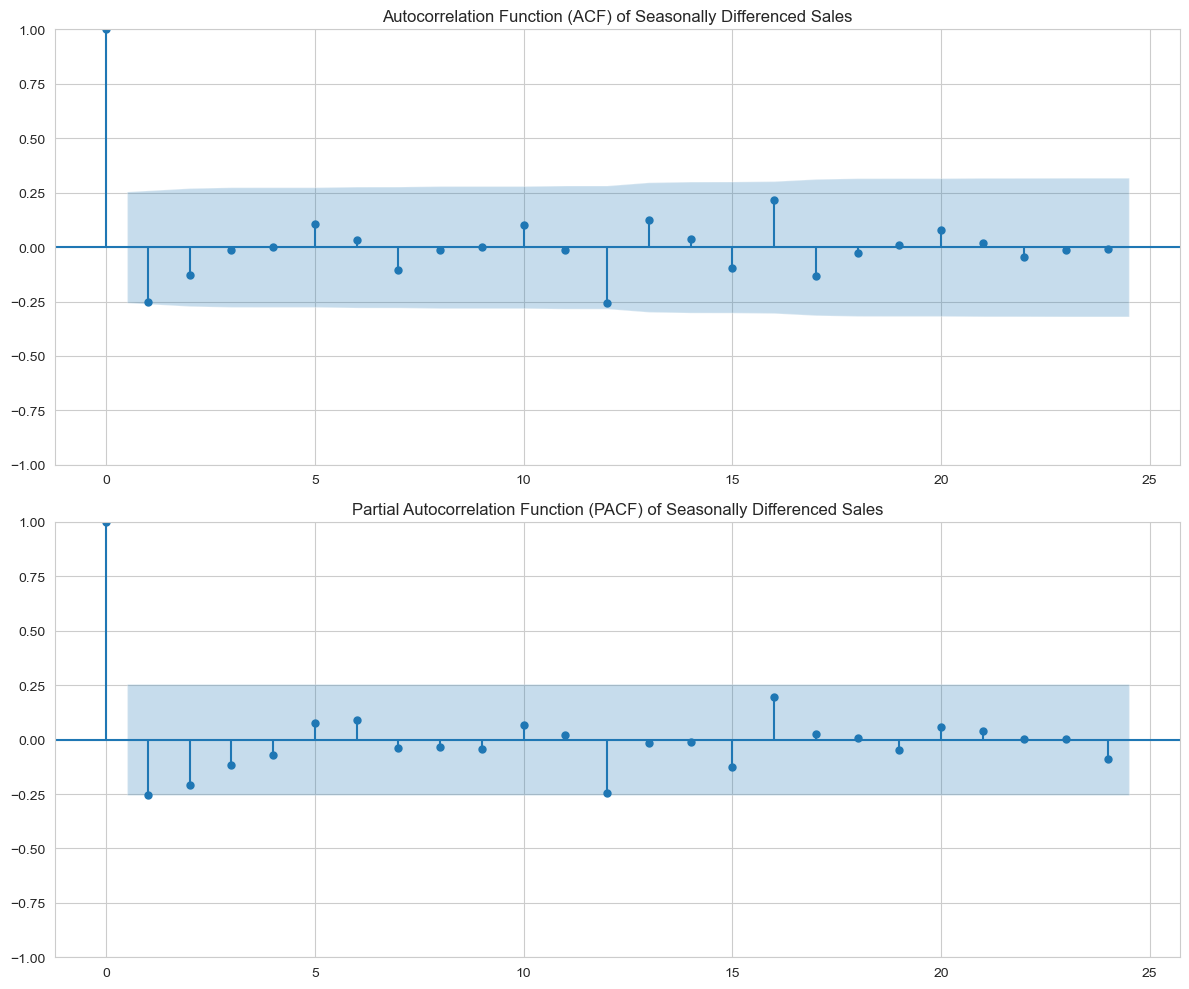

In [12]:
# Plot ACF and PACF of the seasonally differenced series
# Adjusting lags to be less than 50% of the sample size (59 entries), so choosing 24.
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(df_diff_seasonal_diff, lags=24, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) of Seasonally Differenced Sales')
axes[0].grid(True)

plot_pacf(df_diff_seasonal_diff, lags=24, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) of Seasonally Differenced Sales')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('acf_pacf_seasonally_differenced.png')
plt.show()

ve successfully generated the ACF and PACF plots for the seasonally differenced sales data. Analyzing these plots helps us determine the appropriate orders for the SARIMA model:

Non-Seasonal Orders (p, q): Both the ACF and PACF plots show a significant spike at lag 1 that then quickly drop off. This suggests potential values of p=1 and q=1.

Seasonal Orders (P, Q): Both plots also show a significant spike at the seasonal lag of 12. This indicates seasonal autoregressive and/or moving average components at P=1 and Q=1.

Differencing Orders (d, D, s): We've already determined these from our stationarity tests:

d=1 (first-order regular differencing)

D=1 (first-order seasonal differencing)

s=12 (seasonal period for monthly data)

Combining these, a strong candidate for our SARIMA model order is SARIMA(1, 1, 1)(1, 1, 1, 12).

Now, let's fit this SARIMA model to your original sales data and then generate forecasts for the next 24 months. We'll also ensure that the forecasted sales values are not negative.



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/var/folders/g3/jk_3rrgx6175wxmzkdyxs5j80000gn/T/ipykernel_56414/2429062923.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fo


SARIMA(0,1,1)(0,1,1,12) Model Summary (fitted on data until 2021-12-31):
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -552.855
Date:                            Tue, 22 Jul 2025   AIC                           1111.710
Time:                                    08:48:15   BIC                           1116.199
Sample:                                01-31-2017   HQIC                          1113.220
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4625   8.11e-26   -5.7e

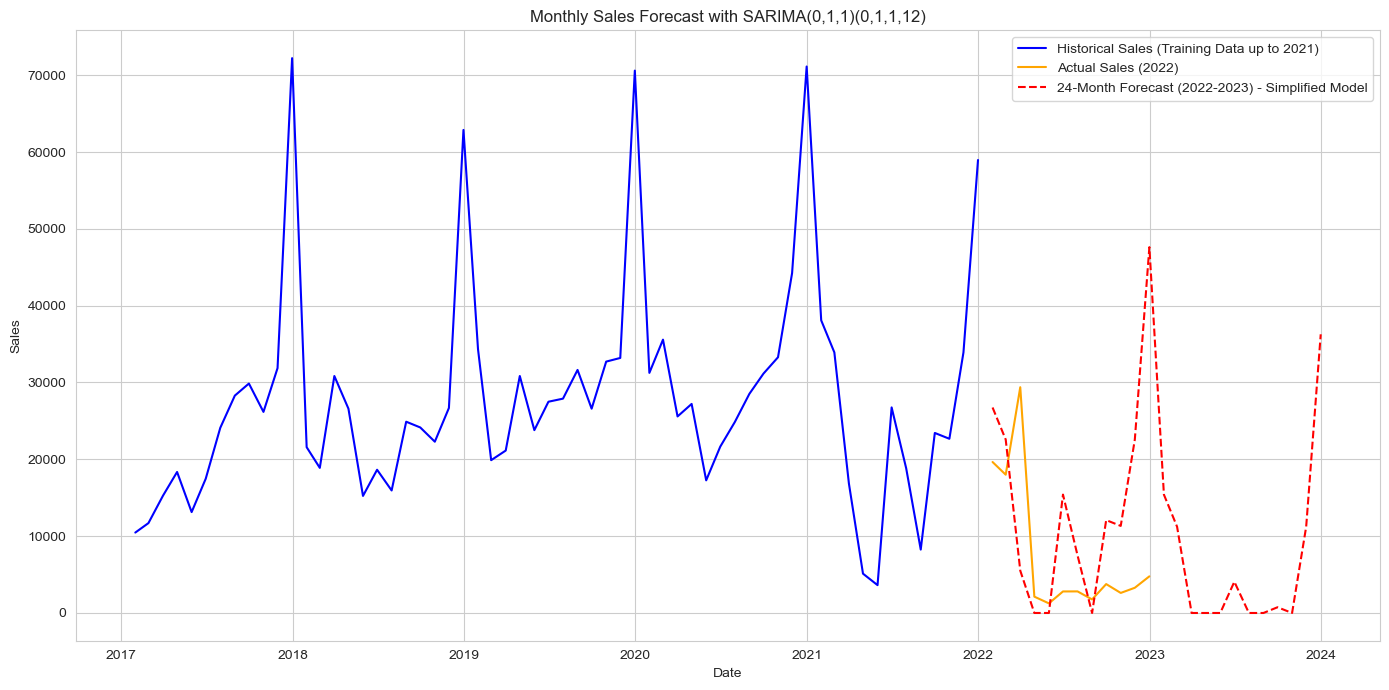

In [13]:
# 1. Split the data: training data until 2021-12-31
train_data = df['Sales'].loc[:'2021-12-31']
test_data = df['Sales'].loc['2022-01-01':]

# Define the SIMPLIFIED SARIMA model parameters
order = (0, 1, 1)        # (p, d, q) - simplified non-seasonal MA(1)
seasonal_order = (0, 1, 1, 12) # (P, D, Q, s) - simplified seasonal MA(1)

# 2. Fit the SARIMA model on the training data
try:
    model_simplified = sm.tsa.statespace.SARIMAX(train_data,
                                                 order=order,
                                                 seasonal_order=seasonal_order,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)

    results_simplified = model_simplified.fit(disp=False)
    print("\nSARIMA(0,1,1)(0,1,1,12) Model Summary (fitted on data until 2021-12-31):")
    print(results_simplified.summary())

    # 3. Generate forecasts for the next 24 months, starting from 2022-01-31
    forecast_start_date = train_data.index.max() + pd.DateOffset(months=1)
    forecast_end_date = train_data.index.max() + pd.DateOffset(months=24)

    forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='M')

    forecast_simplified = results_simplified.predict(start=len(train_data), end=len(train_data) + 24 - 1)
    forecast_simplified.index = forecast_index

    # 4. Ensure sales cannot be negative
    forecast_simplified = forecast_simplified.apply(lambda x: max(0, x))

    print("\nSales Forecast (Simplified Model) for 24 months (2022-01-31 to 2023-12-31):")
    print(forecast_simplified)

    # 5. Visualize the historical data, actual 2022 sales, and the 24-month forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data, label='Historical Sales (Training Data up to 2021)', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Sales (2022)', color='orange', linestyle='-')
    plt.plot(forecast_simplified.index, forecast_simplified, label='24-Month Forecast (2022-2023) - Simplified Model', color='red', linestyle='--')

    plt.title('Monthly Sales Forecast with SARIMA(0,1,1)(0,1,1,12)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('sarima_forecast_simplified_2022_onwards.png')
    plt.show()

except Exception as e:
    print(f"An error occurred during SARIMA model fitting or forecasting with simplified parameters: {e}")
    print("If this model also fails, consider trying SARIMA(1,1,0)(1,1,0,12) or exploring other forecasting methods.")

***
we try to train the model until 2020 now and make 3 year predictions starting 2021
***

In [14]:
# 1. Split the data: training data until 2020-12-31
train_data_new = df['Sales'].loc[:'2020-12-31']
# Test data will be actual sales from 2021-01-01 to 2022-12-31 for comparison
test_data_new = df['Sales'].loc['2021-01-01':]

print("New Training data (up to 2020-12-31) head:")
print(train_data_new.head())
print("\nNew Training data tail:")
print(train_data_new.tail())
print(f"\nNew Training data length: {len(train_data_new)} months")

# Define the SIMPLIFIED SARIMA model parameters (from previous analysis)
order = (0, 1, 1)        # (p, d, q)
seasonal_order = (0, 1, 1, 12) # (P, D, Q, s)

# 2. Fit the SARIMA model on the new training data
try:
    model_new = sm.tsa.statespace.SARIMAX(train_data_new,
                                          order=order,
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

    results_new = model_new.fit(disp=False)
    print("\nSARIMA(0,1,1)(0,1,1,12) Model Summary (fitted on data until 2020-12-31):")
    print(results_new.summary())

    # 3. Generate forecasts for the next 36 months (3 years), starting from 2021-01-31
    forecast_start_date_new = train_data_new.index.max() + pd.DateOffset(months=1)
    forecast_end_date_new = train_data_new.index.max() + pd.DateOffset(months=36) # 36 months after 2020-12-31 is 2023-12-31

    forecast_index_new = pd.date_range(start=forecast_start_date_new, end=forecast_end_date_new, freq='M')

    # Get the forecasts for 36 steps ahead
    forecast_new = results_new.predict(start=len(train_data_new), end=len(train_data_new) + 36 - 1)
    forecast_new.index = forecast_index_new

    # 4. Ensure sales cannot be negative
    forecast_new = forecast_new.apply(lambda x: max(0, x))

    print("\nSales Forecast (Simplified Model) for 36 months (2021-01-31 to 2023-12-31):")
    print(forecast_new)

except Exception as e:
    print(f"An error occurred during SARIMA model fitting or forecasting with simplified parameters: {e}")
    print("If this model also fails, consider trying SARIMA(1,1,0)(1,1,0,12) or exploring other forecasting methods.")

New Training data (up to 2020-12-31) head:
Date
2017-01-31    10467.06475
2017-02-28    11699.28566
2017-03-31    15271.09515
2017-04-30    18352.78914
2017-05-31    13132.97085
Name: Sales, dtype: float64

New Training data tail:
Date
2020-08-31    28521.53526
2020-09-30    31154.37420
2020-10-31    33286.57768
2020-11-30    44245.25289
2020-12-31    71129.05097
Name: Sales, dtype: float64

New Training data length: 48 months

SARIMA(0,1,1)(0,1,1,12) Model Summary (fitted on data until 2020-12-31):
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -212.085
Date:                            Tue, 22 Jul 2025   AIC                            430.170
Time:                                    08:48:15   BIC                            433.303
Sample:                                0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/var/folders/g3/jk_3rrgx6175wxmzkdyxs5j80000gn/T/ipykernel_56414/673163714.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index_new = pd.date_range(start=forecast_start_date_new, end=forecast_end_date_new, freq='M')


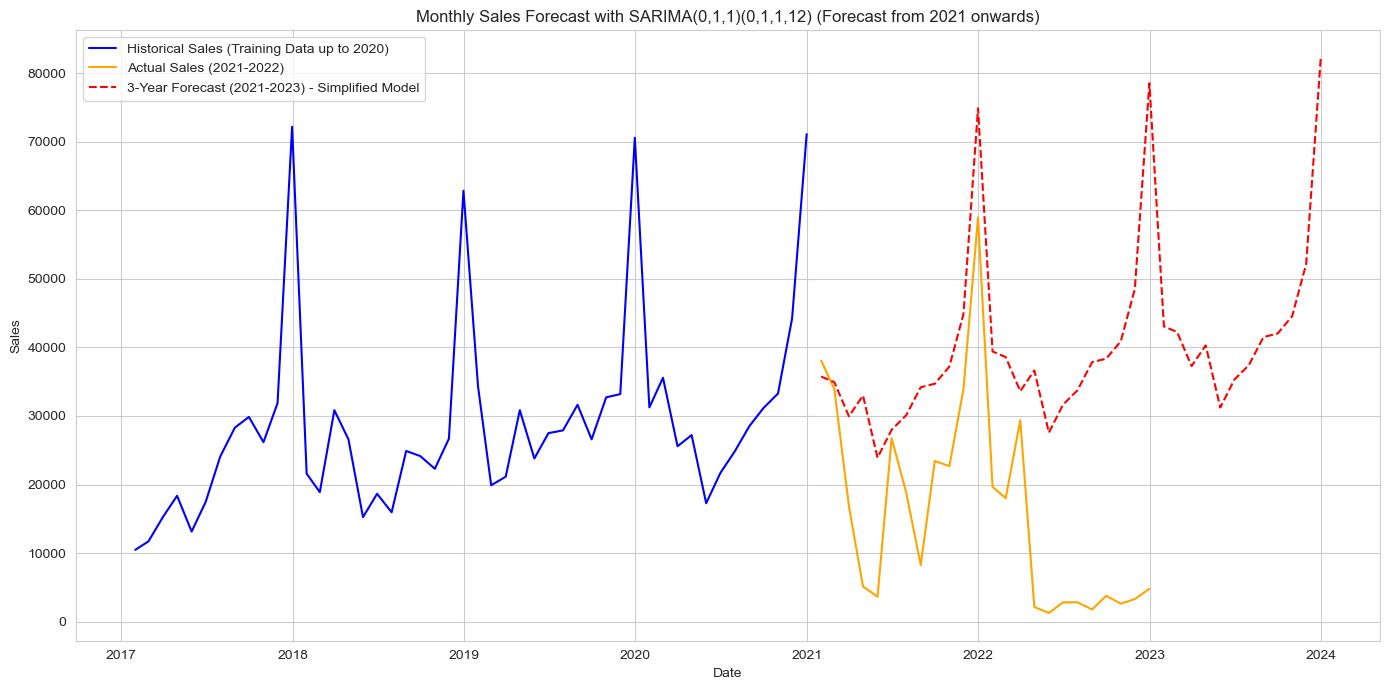

In [15]:
# 5. Visualize the historical data, actual sales (2021-2022), and the 3-year forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data_new.index, train_data_new, label='Historical Sales (Training Data up to 2020)', color='blue')
plt.plot(test_data_new.index, test_data_new, label='Actual Sales (2021-2022)', color='orange', linestyle='-')
plt.plot(forecast_new.index, forecast_new, label='3-Year Forecast (2021-2023) - Simplified Model', color='red', linestyle='--')

plt.title('Monthly Sales Forecast with SARIMA(0,1,1)(0,1,1,12) (Forecast from 2021 onwards)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('sarima_forecast_2021_onwards_3_years.png')
plt.show()

### this is the prediction of sales if the supply was normal. this graph can be presented to the HQ, stating based on previous performance, there's a huge potential for growth if the product supply was increased. Therefore after the production resumes to normal, there would be no need to cut down on inventory allocations based on recent sales numbers.